# Machine Learning in Genomics

In [1]:
# Packages 
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold, GridSearchCV  
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix
from sklearn.cluster import DBSCAN, KMeans
# wilcoxon rank-sum test
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC 
from scipy.stats import mannwhitneyu
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
import umap.umap_ as umap
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.ensemble import RandomForestClassifier


## DATASET 1 Mice Protein Expression data set
URL: https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression  

This Dataset contains 1080 observations with 82 features, 77 of which indicate the protein expression level of an individual protein in each mouse. The other 5 features provide the unique ID for each mouse and indicate which of the 8 classes each sample belongs to according to their respective genotypes, behaviour, and treatment. These classes are segregated based on whether the sample is trisomic (contains three of a particular chromosome), whether the sample has been stimulated to learn and whether memantine has been given to the sample. The classes are designated as:

- c-CS-s: control mice, stimulated to learn, injected with saline 
- c-CS-m: control mice, stimulated to learn, injected with memantine 
- c-SC-s: control mice, not stimulated to learn, injected with saline 
- c-SC-m: control mice, not stimulated to learn, injected with memantine 
- t-CS-s: trisomy mice, stimulated to learn, injected with saline 
- t-CS-m: trisomy mice, stimulated to learn, injected with memantine 
- t-SC-s: trisomy mice, not stimulated to learn, injected with saline 
- t-SC-m: trisomy mice, not stimulated to learn, injected with memantine 


**AIM**: To identify the subset of proteins that are discriminate between the classes which would therefore indicate the proteins associated with the disorder.

### Data Analysis <a name="da"></a>


**Data retrieval:**

In [2]:

file_name1 = 'Data_Cortex_Nuclear.xls'
data1 = pd.read_excel(file_name1)
data1.head()



,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


In [3]:
data1.shape

(1080, 82)

**Data Wrangling**:
1. Remove redundant information
2. Check for outliers and missing values and deal with accordingly 
3. label encode target variable 
4. Normalise data 

In [4]:
# Seperate features and target variable and remove categorial features from data
Y1_1 =pd.DataFrame()
Y1 = data1['class']
Y1_1['class'] = Y1.copy()
print(Y1_1.value_counts())
data1 = data1.drop(['MouseID','Genotype','Treatment','Behavior','class'],axis=1)


class 
c-CS-m    150
c-SC-m    150
c-CS-s    135
c-SC-s    135
t-CS-m    135
t-SC-m    135
t-SC-s    135
t-CS-s    105
dtype: int64


In [5]:
# label encode target variable 
Labelencoder = LabelEncoder()
Labelencoder.fit_transform(Y1)
Y_name_mapping = dict(zip(Labelencoder.classes_, Labelencoder.transform(Labelencoder.classes_)))
Y1 = Labelencoder.fit_transform(Y1)
print(Y_name_mapping)


{'c-CS-m': 0, 'c-CS-s': 1, 'c-SC-m': 2, 'c-SC-s': 3, 't-CS-m': 4, 't-CS-s': 5, 't-SC-m': 6, 't-SC-s': 7}


In [6]:
# Check for missing values: 
print(f'Total Number of Missing Values: {data1.isnull().sum(axis=1).sum()}')
data1.isnull().sum(axis=0)

Total Number of Missing Values: 1396


DYRK1A_N       3
ITSN1_N        3
BDNF_N         3
NR1_N          3
NR2A_N         3
            ... 
SYP_N          0
H3AcK18_N    180
EGR1_N       210
H3MeK4_N     270
CaNA_N         0
Length: 77, dtype: int64

Because the data contains a substantial amount of missing values (more than 50% of rows) these cannot be imputed without effecting the trends present in the overall dataset. Because the dataset is relatively small the values can be imputed with the mean of each feature without substantial data leakage :

In [7]:
for column in data1:
    if data1[column].isnull().sum(axis=0) > 0:
        data1[column] = data1[column].replace(np.NaN,data1[column].mean())
print(f'Total Number of Missing Values: {data1.isnull().sum(axis=1).sum()}')

Total Number of Missing Values: 0


In [8]:
# Check for outliers 
no_out = abs(data1[(np.abs(stats.zscore(data1)) > 3).all(axis=1)].shape[0])

print('No. of outliers:',no_out)
print('Percentage of outliers:',round(no_out/data1.shape[0]*100,2),'%')


No. of outliers: 0
Percentage of outliers: 0.0 %


Min-max scalling is used to normalise the dataset

In [9]:
scaler = MinMaxScaler()
data_ary = scaler.fit_transform(data1)  # fitting and tranforming the dataframe
data1_scaled = pd.DataFrame(data_ary, columns=data1.columns)    # changing back to dataframe as sk learn only outputs a np array
data1_scaled.tail()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
1075,0.046197,0.092577,0.365672,0.313684,0.127872,0.312096,0.423753,0.186230,0.488562,0.110645,...,0.591238,0.527476,0.299172,0.530654,0.572176,0.230480,0.597619,0.388482,0.725820,0.504334
1076,0.053509,0.097062,0.357235,0.342243,0.157739,0.395191,0.468154,0.190968,0.535204,0.114722,...,0.629077,0.527373,0.299172,0.506703,0.527466,0.232818,0.614760,0.371843,0.614028,0.504110
1077,0.035163,0.063556,0.311370,0.165795,0.071655,0.330863,0.384915,0.105509,0.374040,0.080099,...,0.666803,0.662723,0.299172,0.565002,0.425904,0.326363,0.603927,0.484631,0.811962,0.547100
1078,0.032018,0.071071,0.337173,0.224787,0.095856,0.306129,0.433086,0.121245,0.409605,0.086829,...,0.745142,0.691532,0.299172,0.634370,0.647984,0.277565,0.640497,0.571336,0.844450,0.529739
1079,0.066342,0.091503,0.370133,0.313976,0.127028,0.394619,0.504969,0.166308,0.572903,0.111720,...,0.674147,0.719117,0.299172,0.564459,0.596908,0.322821,0.638311,0.577914,0.844210,0.508336


**Machine Learning Models**

Text(18.353277777777762, 0.5, 'PC2')

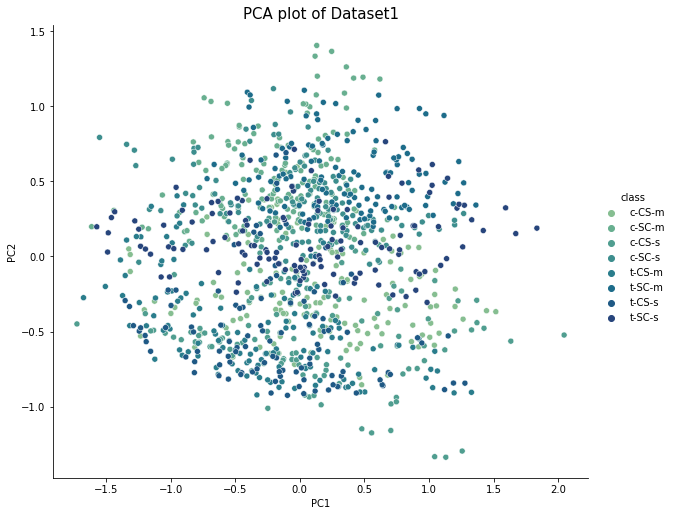

In [10]:
pca = PCA(n_components=8)
pc = pca.fit_transform(data1_scaled)
X_pca = pd.DataFrame(data = pc)
X_pca = pd.concat([X_pca.reset_index().drop(['index'],axis=1),Y1_1.reset_index().drop(['index'],axis=1)], axis=1)
sns.pairplot(x_vars=0, y_vars=1,data=X_pca, hue="class",palette='crest',size=7,aspect=1.2)
plt.title('PCA plot of Dataset1',fontsize=15)
plt.xlabel('PC1')
plt.ylabel('PC2')

Split the dataset:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data1_scaled,Y1,test_size=0.3, random_state=999)
     

cv_method = StratifiedKFold(n_splits=5, shuffle=True, random_state=999)

**Logistic regression**

In [12]:
pipe_lr = Pipeline(steps=[
                          ('lr', LogisticRegression())])


# Setting up the parameters to be hyperoptimised
params_pipe_lr = { 'lr__C':[100, 10, 1.0, 0.1, 0.01],
                'lr__solver':['newton-cg', 'lbfgs', 'liblinear'],
                'lr__max_iter' : [100, 1000,2500, 5000],
                'lr__penalty' : ['l1', 'l2', 'elasticnet', 'none']}


# Using Gridsearch to hyperoptimise the params as well as performing cross validation
gs_pipe_lr = GridSearchCV(estimator=pipe_lr, 
                           param_grid=params_pipe_lr, 
                           cv=cv_method,
                           refit=True,
                           n_jobs=-2,
                           scoring='f1_micro',   # Must ensure that the scoring metric is set to ROC_AUC as defualt value is None
                           verbose=1) 

In [13]:
gs_pipe_lr.fit(X_train, y_train)
print(f'Best Params: {gs_pipe_lr.best_params_}')
print(f'Best Score: {gs_pipe_lr.best_score_}')

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Params: {'lr__C': 100, 'lr__max_iter': 100, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Best Score: 0.9907371906587661


f1 score: 0.9969


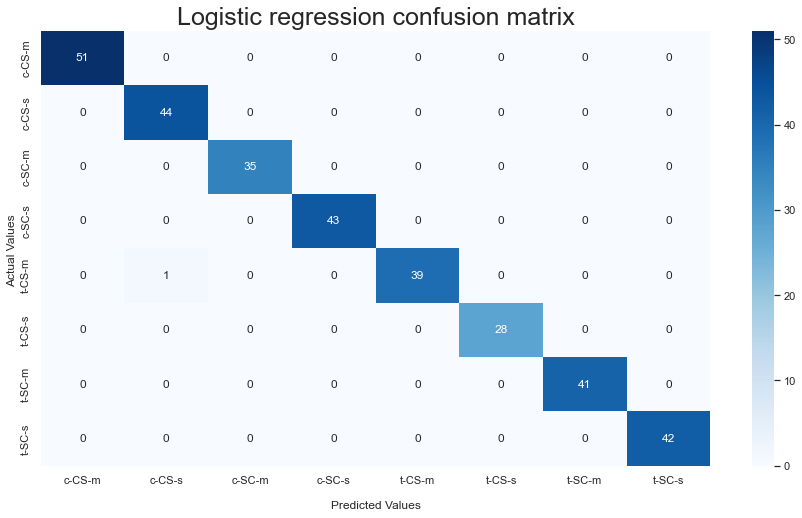

In [14]:
# setting best model from grid search parameters
lr_model = gs_pipe_lr.best_estimator_
# predicting on test values
lr_pred = lr_model.predict(X_test)
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, lr_pred)
sns.set(rc = {'figure.figsize':(15,8)})
plt.title('Logistic regression confusion matrix',fontsize=25)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(Y_name_mapping.keys())
ax.yaxis.set_ticklabels(Y_name_mapping.keys())

print('f1 score: '+str(round(f1_score(lr_pred, y_test,average='micro'),4)))

f1 score: 0.8179


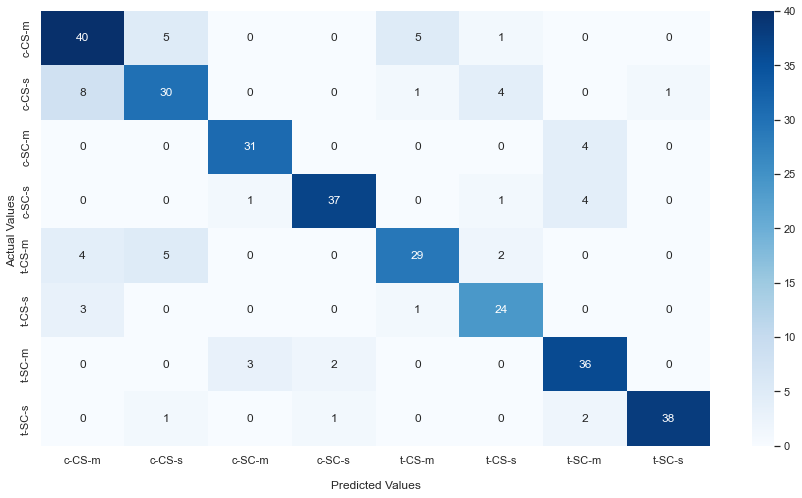

In [15]:
# Using Umap reduction 
pca = umap.UMAP() #change to 3 components
newdf_train = pca.fit_transform(X_train)
newdf_valid = pca.transform(X_test)
features_train = pd.DataFrame(newdf_train)
features_valid = pd.DataFrame(newdf_valid)
dt_model = DecisionTreeClassifier(criterion='gini',max_depth=10,min_samples_split=5,random_state=999)
dt_model.fit(features_train,y_train)
dt_pred = dt_model.predict(features_valid)
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, dt_pred)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(Y_name_mapping.keys())
ax.yaxis.set_ticklabels(Y_name_mapping.keys())

print('f1 score: '+str(round(f1_score(dt_pred, y_test,average='micro'),4)))

In [16]:
X_test

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
576,0.220853,0.279266,0.516401,0.395791,0.275350,0.302375,0.418515,0.136498,0.441737,0.217616,...,0.198253,0.138484,0.299172,0.369513,0.266694,0.223442,0.085713,0.002341,0.110210,0.794049
922,0.137157,0.243505,0.592661,0.456159,0.315900,0.307390,0.399462,0.158769,0.479476,0.168427,...,0.230150,0.249450,0.108368,0.463371,0.163962,0.590724,0.058446,0.091335,0.160857,0.849810
855,0.160960,0.264502,0.621427,0.561516,0.346570,0.369593,0.439563,0.533750,0.862632,0.183455,...,0.473018,0.318157,0.191384,0.619655,0.143252,0.569424,0.246733,0.183513,0.219732,0.785946
735,0.078088,0.136691,0.628636,0.578645,0.446769,0.399589,0.564422,0.331956,0.613627,0.235672,...,0.300974,0.359346,0.299172,0.600654,0.315311,0.284417,0.224755,0.304119,0.698382,0.056513
305,0.167369,0.227008,0.783725,0.552805,0.586264,0.462922,0.532190,0.565840,0.740556,0.255291,...,0.392483,0.359346,0.193859,0.544265,0.152237,0.217039,0.237016,0.186862,0.332097,0.475503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,0.043493,0.052147,0.421237,0.277230,0.115644,0.295899,0.406272,0.150148,0.328703,0.124390,...,0.661189,0.393972,0.337070,0.740107,0.448932,0.320237,0.201639,0.573524,0.351469,0.202353
187,0.021129,0.030278,0.267565,0.195805,0.214360,0.299520,0.301750,0.482617,0.197320,0.082118,...,0.305825,0.220362,0.200521,0.650989,0.302939,0.267274,0.107353,0.258434,0.195073,0.255827
535,0.033609,0.059595,0.354452,0.274320,0.189682,0.327328,0.360947,0.191257,0.299446,0.108985,...,0.461189,0.386360,0.348254,0.736442,0.483702,0.391417,0.201101,0.328711,0.510154,0.566119
424,0.144403,0.154748,0.596296,0.440008,0.434544,0.440969,0.563175,0.443414,0.725830,0.190887,...,0.137932,0.359346,0.299172,0.509124,0.076313,0.172916,0.224755,0.304119,0.332097,0.588912


**SVM**

In [17]:

# Setting up the KNN model Pipline 
pipe_SVM = Pipeline(steps=[
                           ('svc', SVC(class_weight='balanced'))])


# Setting up the parameters to be hyperoptimised
params_pipe_SVM = { 'svc__kernel': ['rbf', 'linear', 'poly'],
                    'svc__C': [1, 5, 10],
                    'svc__gamma': [0.0001, 0.0005, 0.001]}


# Using Gridsearch to hyperoptimise the params as well as performing cross validation
gs_pipe_SVM = GridSearchCV(estimator=pipe_SVM, 
                           param_grid=params_pipe_SVM, 
                           cv=cv_method,
                           refit=True,
                           n_jobs=-2,
                           scoring='f1_micro',   # Must ensure that the scoring metric is set to ROC_AUC as defualt value is None
                           verbose=1) 

In [18]:
gs_pipe_SVM.fit(X_train, y_train)
print(f'Best Params: {gs_pipe_SVM.best_params_}')
print(f'Best Score: {gs_pipe_SVM.best_score_}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Params: {'svc__C': 5, 'svc__gamma': 0.0001, 'svc__kernel': 'linear'}
Best Score: 0.9907284768211919


f1 score: 0.9846


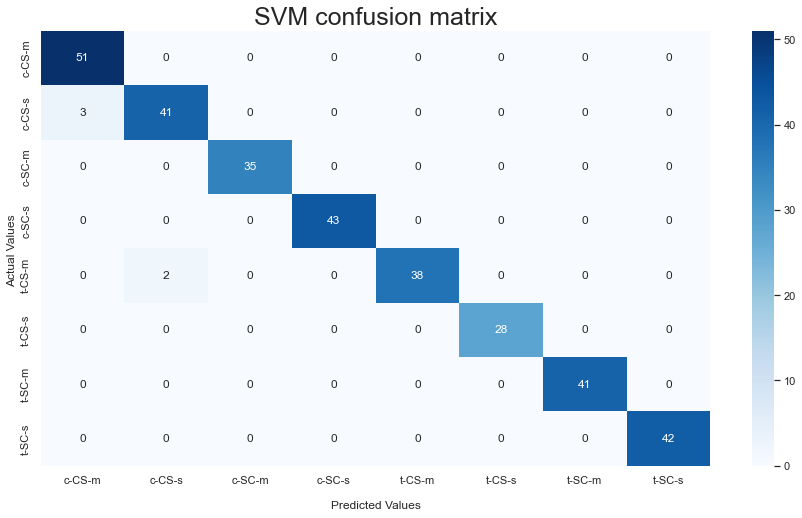

In [19]:
# setting best model from grid search parameters
svc_model = gs_pipe_SVM.best_estimator_
# predicting on test values
svc_pred = svc_model.predict(X_test)
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, svc_pred)
sns.set(rc = {'figure.figsize':(15,8)})
plt.title('SVM confusion matrix',fontsize=25)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(Y_name_mapping.keys())
ax.yaxis.set_ticklabels(Y_name_mapping.keys())

print('f1 score: '+str(round(f1_score(svc_pred, y_test,average='micro'),4)))

In [20]:
def list_compare(list1,list2):
   list1n = []
   list2n = []
   for val in list1:
      list1n.append(val[0])
   for val in list2:
      list2n.append(val[0])
   
   new_list = []
   for val in list1:
      if val in list2:
         continue
      else: 
         new_list.append(val)
   return new_list

In [21]:
def compare_top_20_features(map1,map2):
    clf1 = RandomForestClassifier(random_state=999)
    clf2 = RandomForestClassifier(random_state=999)
    Y1_1['Binary class 1'] = Y1_1['class'].map(map1)
    clf1.fit(data1_scaled, Y1_1["Binary class 1"].values)
    sorted_feature_weight_idxes1 = np.argsort(clf1.feature_importances_)[::-1]
    most_important_features1 = np.take_along_axis(np.array(data1_scaled.iloc[:, :].columns.tolist()), sorted_feature_weight_idxes1, axis=0)
    most_important_weights1 = np.take_along_axis(np.array(clf1.feature_importances_), sorted_feature_weight_idxes1, axis=0)
    f_list1 = list(zip(most_important_features1, most_important_weights1))[0:20]

    Y1_1['Binary class 2'] = Y1_1['class'].map(map2)
    clf2.fit(data1_scaled, Y1_1["Binary class 2"].values)
    sorted_feature_weight_idxes2 = np.argsort(clf2.feature_importances_)[::-1]
    most_important_features2 = np.take_along_axis(np.array(data1_scaled.iloc[:, :].columns.tolist()), sorted_feature_weight_idxes2, axis=0)
    most_important_weights2 = np.take_along_axis(np.array(clf2.feature_importances_), sorted_feature_weight_idxes2, axis=0)
    f_list2 = list(zip(most_important_features2, most_important_weights2))[0:20]

    final_list=list_compare(f_list1,f_list2)
    return final_list

Get list of proteins relavent for learning: compare c-CS-s and c-SC-s:

In [22]:
map1= {'c-CS-m': 0, 'c-CS-s': 1, 'c-SC-m': 0, 'c-SC-s': 0, 't-CS-m': 0, 't-CS-s': 0, 't-SC-m': 0, 't-SC-s': 0}
map2= {'c-CS-m': 0, 'c-CS-s': 0, 'c-SC-m': 0, 'c-SC-s': 1, 't-CS-m': 0, 't-CS-s': 0, 't-SC-m': 0, 't-SC-s': 0}

learning_list = compare_top_20_features(map1,map2)

Get list of proteins relavent to the contorl: compare c-CS-s and t-CS-s:

In [23]:
map1= {'c-CS-m': 0, 'c-CS-s': 1, 'c-SC-m': 0, 'c-SC-s': 0, 't-CS-m': 0, 't-CS-s': 0, 't-SC-m': 0, 't-SC-s': 0}
map2= {'c-CS-m': 0, 'c-CS-s': 0, 'c-SC-m': 0, 'c-SC-s': 0, 't-CS-m': 0, 't-CS-s': 1, 't-SC-m': 0, 't-SC-s': 0}
control_list = compare_top_20_features(map1,map2)
control_list

[('pPKCAB_N', 0.06338697423746435),
 ('Ubiquitin_N', 0.04325297261616203),
 ('Tau_N', 0.038609531913254995),
 ('pGSK3B_N', 0.037986869723980694),
 ('SOD1_N', 0.03694990331870064),
 ('nNOS_N', 0.03431421737060416),
 ('pAKT_N', 0.028539844331271387),
 ('CaNA_N', 0.02638153595766684),
 ('IL1B_N', 0.02155354358599168),
 ('pBRAF_N', 0.021347884913195503),
 ('pERK_N', 0.02073687064813238),
 ('pMEK_N', 0.02065520859703634),
 ('pJNK_N', 0.02004200341827733),
 ('DYRK1A_N', 0.019917321699869855),
 ('ITSN1_N', 0.018519689751809332),
 ('pNUMB_N', 0.01818137255902592),
 ('APP_N', 0.017064827698755787),
 ('ADARB1_N', 0.01670351319195188),
 ('BRAF_N', 0.015826184928265107),
 ('pELK_N', 0.01549646124798681)]

Get list of proteins relavent to the drug Memantime: compare t-CS-m and t-CS-s:

In [24]:
map1= {'c-CS-m': 0, 'c-CS-s': 0, 'c-SC-m': 0, 'c-SC-s': 0, 't-CS-m': 1, 't-CS-s': 0, 't-SC-m': 0, 't-SC-s': 0}
map2= {'c-CS-m': 0, 'c-CS-s': 0, 'c-SC-m': 0, 'c-SC-s': 0, 't-CS-m': 0, 't-CS-s': 1, 't-SC-m': 0, 't-SC-s': 0}
memantine_list = compare_top_20_features(map1,map2)
# remove all proteins not relavent to the drug 
memantine_list = list_compare(memantine_list,control_list)
memantine_list = list_compare(memantine_list,learning_list)


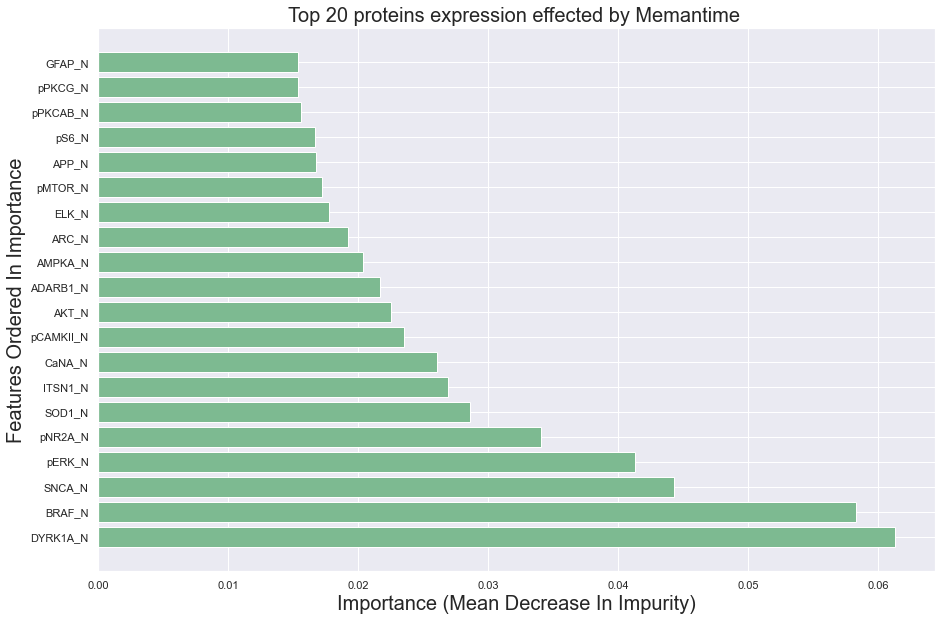

In [25]:
best_feats = []
feat_imp = []
for val in memantine_list:
    best_feats.append(val[0])
    feat_imp.append(val[1])

def importance_plot(b_feat, score):   
    plt.figure(figsize=(15,10))
    plt.barh(b_feat, score, align='center',  color="#7dba91")
    plt.title('Top 20 proteins expression effected by Memantime ' , fontsize = 20)
    plt.xlabel("Importance (Mean Decrease In Impurity)", fontsize = 20)
    plt.ylabel("Features Ordered In Importance", fontsize = 20)
    plt.show()

importance_plot(best_feats, feat_imp)

#### **Analysis of the performance  under varying training set sizes**

In [26]:

crosval_scores =[]
test_scores = []
train_scores = []
test_size = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]

cv_method = StratifiedKFold(n_splits=5, shuffle=True, random_state=999)
for n in test_size:
    if n != 0:
        X_train, X_test, y_train, y_test = train_test_split(data1_scaled,Y1,test_size=n, random_state=999)

        # Setting up the KNN model Pipline 
        pipe_SVM = Pipeline(steps=[
                                ('svc', SVC(class_weight='balanced'))])


        # Setting up the parameters to be hyperoptimised
        params_pipe_SVM = { 'svc__kernel': ['rbf', 'linear', 'poly'],
                            'svc__C': [1, 5, 10],
                            'svc__gamma': [0.0001, 0.0005, 0.001]}


        # Using Gridsearch to hyperoptimise the params as well as performing cross validation
        gs_pipe_SVM = GridSearchCV(estimator=pipe_SVM, 
                                param_grid=params_pipe_SVM, 
                                cv=cv_method,
                                refit=True,
                                n_jobs=-2,
                                scoring='f1_micro',   # Must ensure that the scoring metric is set to ROC_AUC as defualt value is None
                                verbose=1) 
        print(X_train.shape[0])
        gs_pipe_SVM.fit(X_train, y_train)
        print(f'Best Params: {gs_pipe_SVM.best_params_}')
        print(f'Best Score: {gs_pipe_SVM.best_score_}')
        crosval_scores.append(gs_pipe_SVM.best_score_)
        svc_model = gs_pipe_SVM.best_estimator_
        svc_pred = svc_model.predict(X_train)
        score = f1_score(svc_pred, y_train,average='micro')
        train_scores.append(score)
   

    
    # predicting on test values
    svc_pred = svc_model.predict(X_test)
    score = f1_score(svc_pred, y_test,average='micro')
    test_scores.append(score)
    print('f1 score: '+str(round(score,4)))

   



1026
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Params: {'svc__C': 10, 'svc__gamma': 0.0001, 'svc__kernel': 'linear'}
Best Score: 0.9931896755860763
f1 score: 1.0
972
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Params: {'svc__C': 10, 'svc__gamma': 0.0001, 'svc__kernel': 'linear'}
Best Score: 0.9969072164948454
f1 score: 1.0
864
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Params: {'svc__C': 10, 'svc__gamma': 0.0001, 'svc__kernel': 'linear'}
Best Score: 0.9953622798763275
f1 score: 1.0
756
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Params: {'svc__C': 5, 'svc__gamma': 0.0001, 'svc__kernel': 'linear'}
Best Score: 0.9907284768211919
f1 score: 0.9846
648
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Params: {'svc__C': 10, 'svc__gamma': 0.0001, 'svc__kernel': 'linear'}
Best Score: 0.9861180679785331
f1 score: 0.9907
540
Fitting 5 folds for each of 27 candidates, totalling 135 fit

In [27]:
test_sizepercent = [(1-i)*data1.shape[0] for i in test_size]
crosval_scores
test_scores

datadict = {'Size of test set':test_sizepercent,'Cross validation':crosval_scores,'Test set':test_scores,'Train set':train_scores}
df_testsize = pd.DataFrame(datadict)

In [28]:
df_testsize=pd.melt(df_testsize,id_vars='Size of test set',value_vars=['Cross validation','Test set','Train set'],value_name='F1 Score')
df_testsize

,Size of test set,variable,F1 Score
0,1026.0,Cross validation,0.993190
1,972.0,Cross validation,0.996907
2,864.0,Cross validation,0.995362
3,756.0,Cross validation,0.990728
4,648.0,Cross validation,0.986118
5,540.0,Cross validation,0.985185
6,432.0,Cross validation,0.986127
7,324.0,Cross validation,0.953750
8,216.0,Cross validation,0.888584
9,108.0,Cross validation,0.796970


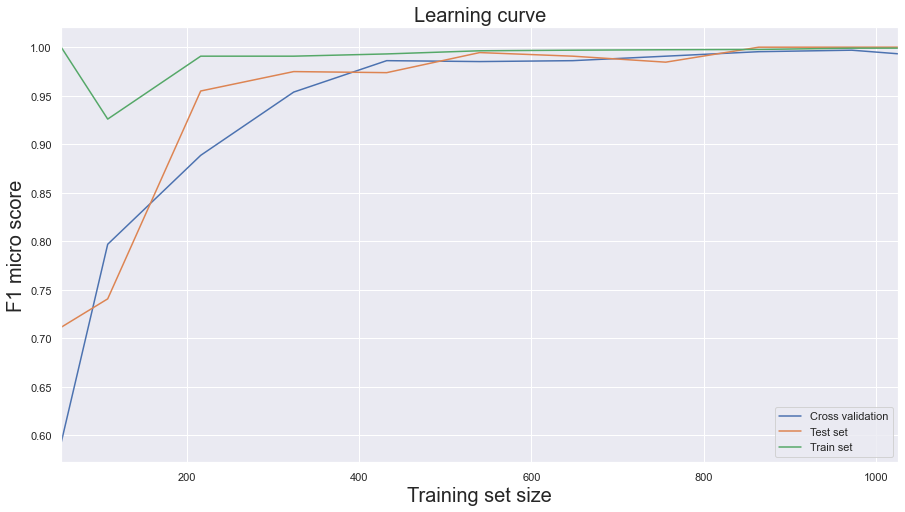

In [29]:
df_testsize
ax=sns.lineplot(x = 'Size of test set', y = 'F1 Score',hue='variable' ,data=df_testsize)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
ax.axes.set_title("Learning curve",fontsize=20)
ax.set_xlabel("Training set size",fontsize=20)
ax.set_ylabel("F1 micro score",fontsize=20)
ax.set(xlim=(54,1026))
plt.show()

-----------
## DATASET 2 Gene expression of RNA sequences dataset

URL: https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq 
This dataset contains 801 observations with 20531 features all of which correspond to the expression level of an RNA sequence/gene of human tumours, the target variable being the type of tumour sequenced.  The tumour types are designated as: 
- BRCA: Breast invasive carcinoma
- KIRC:  Kidney renal cell carcinoma
- COAD: Colon adenocarcinoma
- LUAD: Lung adenocarcinoma
- PRAD: Prostate adenocarcinoma



**AIM**: Using clustering to generate a gene expression profile on the specific tumours and therefore possibly identify those responsible for overall tumour development

**Data retrieval:**

In [30]:
file_name2 = 'data.csv'
file_name2_1 = 'labels.csv'
df2 = pd.read_csv(file_name2)
df2_1= pd.read_csv(file_name2_1)
df2.describe() 

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


**Data Wrangling**:
1. Remove redundant information
2. Check for outliers and missing values and deal with accordingly 
3. label encode target variable 
4. Normalise data 

In [31]:
# Drop sample names: 
data2 = df2.drop(df2.columns[0],axis=1)
labels2 = df2_1.drop(df2_1.columns[0],axis=1)

In [32]:
#Check for missing values:
print(f'Total Number of Missing Values: {data2.isnull().sum(axis=1).sum()}')
data2.shape

Total Number of Missing Values: 0


(801, 20531)

In [33]:
# Check for outliers 
no_out = abs(data2[(np.abs(stats.zscore(data2)) > 3).all(axis=1)].shape[0])

print('No. of outliers:',no_out)
print('Percentage of outliers:',round(no_out/data2.shape[0]*100,2),'%')

No. of outliers: 0
Percentage of outliers: 0.0 %


In [34]:
#Scale data 
scaler = MinMaxScaler()
data_ary = scaler.fit_transform(data2)  # fitting and tranforming the dataframe
X2 = pd.DataFrame(data_ary, columns=data2.columns)    # changing back to dataframe as sk learn only outputs a np array
X2.tail()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
796,0.0,0.299123,0.448290,0.457169,0.537742,0.0,0.417542,0.178813,0.0,0.0,...,0.657772,0.551143,0.504154,0.487040,0.427389,0.639388,0.550697,0.450259,0.775104,0.000000
797,0.0,0.632184,0.734529,0.261181,0.555164,0.0,0.499390,0.000000,0.0,0.0,...,0.715472,0.665219,0.435847,0.711956,0.283854,0.554199,0.672323,0.178114,0.854243,0.000000
798,0.0,0.521014,0.611446,0.620403,0.365829,0.0,0.531252,0.651708,0.0,0.0,...,0.582786,0.436483,0.685620,0.389874,0.358563,0.671438,0.760112,0.323752,0.384804,0.111663
799,0.0,0.415316,0.459798,0.451021,0.531280,0.0,0.778307,0.000000,0.0,0.0,...,0.596177,0.435282,0.881619,0.515437,0.430434,0.461023,0.676725,0.512458,0.482929,0.000000
800,0.0,0.372812,0.627681,0.297049,0.385107,0.0,0.593195,0.000000,0.0,0.0,...,0.721816,0.432790,0.594092,0.992611,0.554643,0.555839,0.742301,0.400151,0.372860,0.000000


In [35]:
# label encode target variable 
Labelencoder = LabelEncoder()
Labelencoder.fit_transform(labels2['Class'])
labels_name_mapping = dict(zip(Labelencoder.classes_, Labelencoder.transform(Labelencoder.classes_)))
labels2['Class'] = Labelencoder.fit_transform(labels2['Class'])
Y2 = labels2
Y2
labels_name_mapping


{'BRCA': 0, 'COAD': 1, 'KIRC': 2, 'LUAD': 3, 'PRAD': 4}

**Dimensionality Reduction**

1. PCA

Text(22.647957299933864, 0.5, 'PC2')

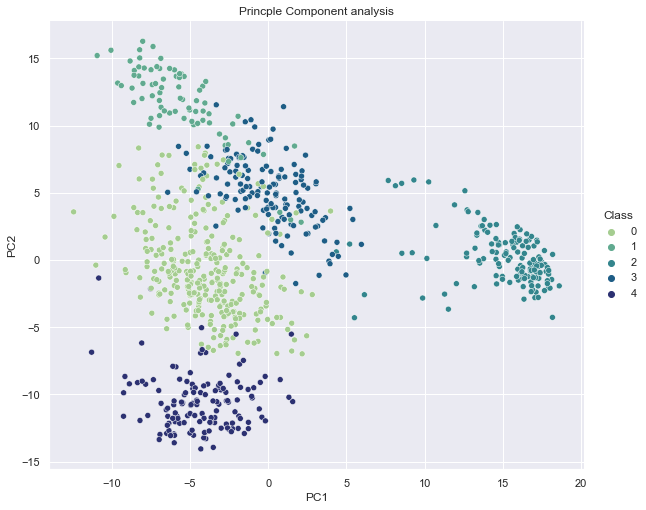

In [36]:
pca = PCA(n_components=5)
pc = pca.fit_transform(X2)
X_pca = pd.DataFrame(data = pc)
X_pca = pd.concat([X_pca.reset_index().drop(['index'],axis=1),Y2.reset_index().drop(['index'],axis=1)], axis=1)
X_pca
pca = sns.pairplot(x_vars=0, y_vars=1,data=X_pca, hue="Class",palette='crest',size=7,aspect=1.2)
plt.title('Princple Component analysis')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.show()

2. T-SNE

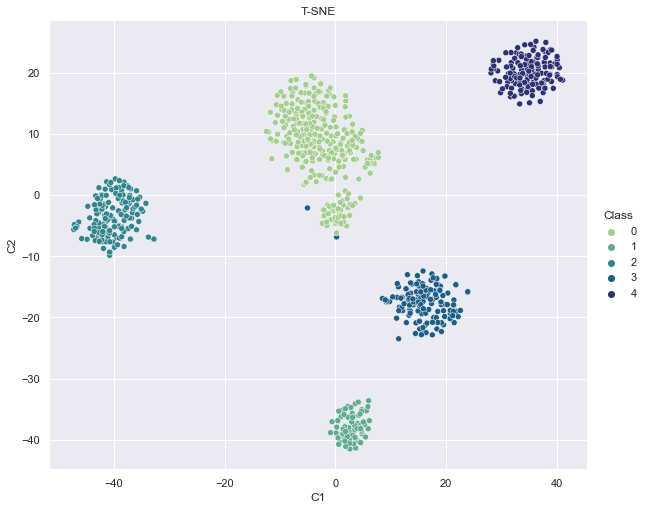

In [37]:
X_tsne = TSNE(n_components=2).fit_transform(X2)
X_tsne = pd.DataFrame(data = X_tsne)
X_tsne = pd.concat([X_tsne.reset_index().drop(['index'],axis=1),Y2.reset_index().drop(['index'],axis=1)], axis=1)

tsne = sns.pairplot(x_vars=0, y_vars=1, data=X_tsne, hue="Class",palette='crest',size=7,aspect=1.2)
plt.title('T-SNE')
plt.xlabel('C1')
plt.ylabel('C2')
plt.show()

3. UMAP reduction:

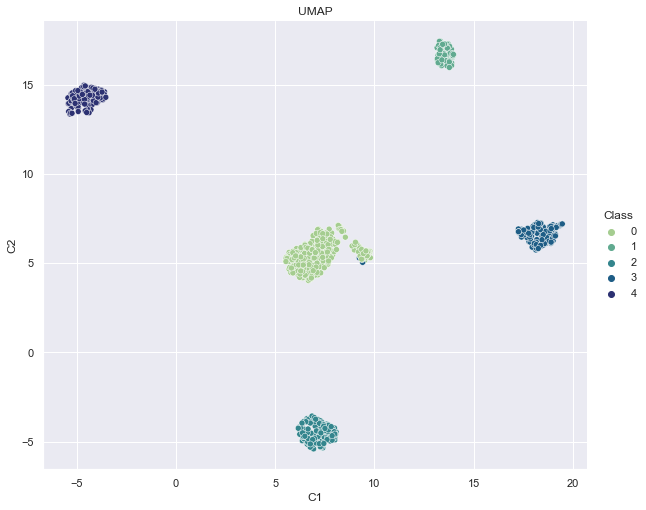

In [38]:
X_umap = umap.UMAP().fit_transform(X2)
X_umap = pd.DataFrame(data=X_umap)
X_umap = pd.concat([X_umap.reset_index().drop(['index'],axis=1),Y2.reset_index().drop(['index'],axis=1)], axis=1)

umapplot=sns.pairplot(x_vars=0, y_vars=1, data=X_umap, hue="Class",palette='crest',size=7,aspect=1.2)
plt.title('UMAP')
plt.xlabel('C1')
plt.ylabel('C2')
plt.show()

As seen above Umap seems to be the best dimensionality reduction method as it seperates the tumor types into very distinct clusters 

**Clustering**
1. **K-Means**

In [39]:
pipe = Pipeline(
    [
           (
              "kmeans",
             KMeans(
                init="k-means++",
                  n_init=50,
                  max_iter=500,
                 random_state=999,
                 n_clusters=5
              ),
          ),
       ]
   )


In [40]:
X2_processed = umap.UMAP().fit_transform(X2)


In [41]:
silhouette_scores = []
ari_scores = []
for n in range(20, 100):
        # This set the number of components for pca,
        # but leaves other steps unchanged
        pipe["kmeans"].n_init = n
        pipe.fit(X2_processed)
   
        silhouette_coef = silhouette_score(
           X2_processed,
            pipe["kmeans"].labels_,
        )
        ari = adjusted_rand_score(
            Y2['Class'],
            pipe["kmeans"].labels_,
        )
   
        # Add metrics to their lists
        silhouette_scores.append(silhouette_coef)
        ari_scores.append(ari)

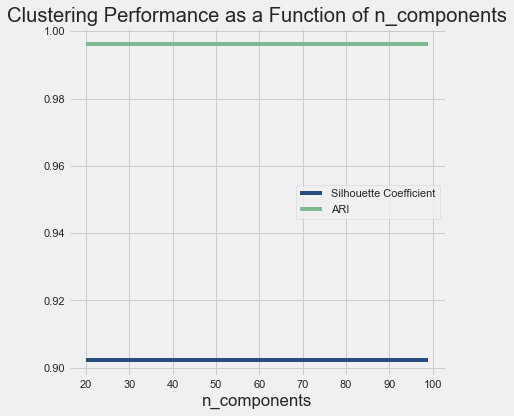

In [42]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 6))
plt.plot(
   range(20, 100),
        silhouette_scores,
        c="#254b7f",
        label="Silhouette Coefficient",
    )
plt.plot(range(20, 100), ari_scores, c="#7dba91", label="ARI")
   
plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance as a Function of n_components")
plt.tight_layout()
sns.color_palette('crest')

plt.show()

**Clustering**
1. **DBSCAN**

In [43]:
pipe = Pipeline(
    [
           (
              "DBS",
              DBSCAN(eps=1)
              ,
          ),
       ]
   )


In [44]:
silhouette_scores = []
ari_scores = []
for n in range(3, 20):
        # This set the number of components for pca,
        # but leaves other steps unchanged
        pipe["DBS"].min_samples = n
        pipe.fit(X2_processed)
   
        silhouette_coef = silhouette_score(
           X2_processed,
            pipe["DBS"].labels_,
        )
        ari = adjusted_rand_score(
            Y2['Class'],
            pipe["DBS"].labels_,
        )
   
        # Add metrics to their lists
        silhouette_scores.append(silhouette_coef)
        ari_scores.append(ari)

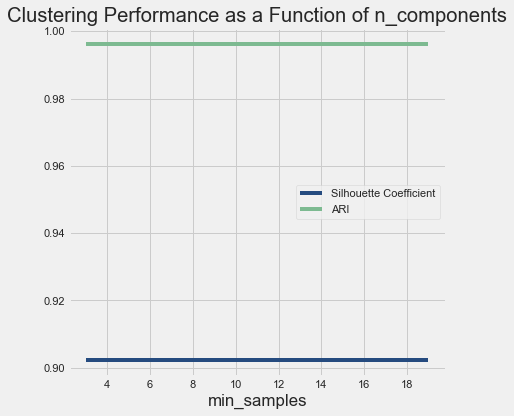

In [45]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 6))
plt.plot(
   range(3, 20),
        silhouette_scores,
        c="#254b7f",
        label="Silhouette Coefficient",
    )
plt.plot(range(3, 20), ari_scores, c="#7dba91", label="ARI")
   
plt.xlabel("min_samples")
plt.legend()
plt.title("Clustering Performance as a Function of n_components")
plt.tight_layout()
plt.show()

In [46]:
pipe = Pipeline(
    [
           (
              "DBS",
              DBSCAN(min_samples=4)
              ,
          ),
       ]
   )
silhouette_scores = []
ari_scores = []
for n in range(1, 20):
        # This set the number of components for pca,
        # but leaves other steps unchanged
        pipe["DBS"].eps = n/2
        pipe.fit(X2_processed)
   
        silhouette_coef = silhouette_score(
           X2_processed,
            pipe["DBS"].labels_,
        )
        ari = adjusted_rand_score(
            Y2['Class'],
            pipe["DBS"].labels_,
        )
   
        # Add metrics to their lists
        silhouette_scores.append(silhouette_coef)
        ari_scores.append(ari)

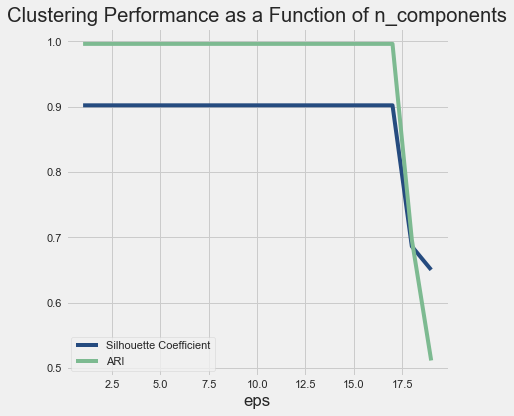

In [47]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 6))
plt.plot(
   range(1, 20),
        silhouette_scores,
        c="#254b7f",
        label="Silhouette Coefficient",
    )
plt.plot(range(1, 20), ari_scores, c="#7dba91", label="ARI")
   
plt.xlabel("eps")
plt.legend()
plt.title("Clustering Performance as a Function of n_components")
plt.tight_layout()
plt.show()

In [48]:
Y_pred =DBSCAN(eps=0.5,min_samples=4).fit_predict(X2_processed)
silhouette_score(X2_processed, Y_pred)


0.9022232

In [49]:
adjusted_rand_score(Y2['Class'], Y_pred)

0.9962578040012737

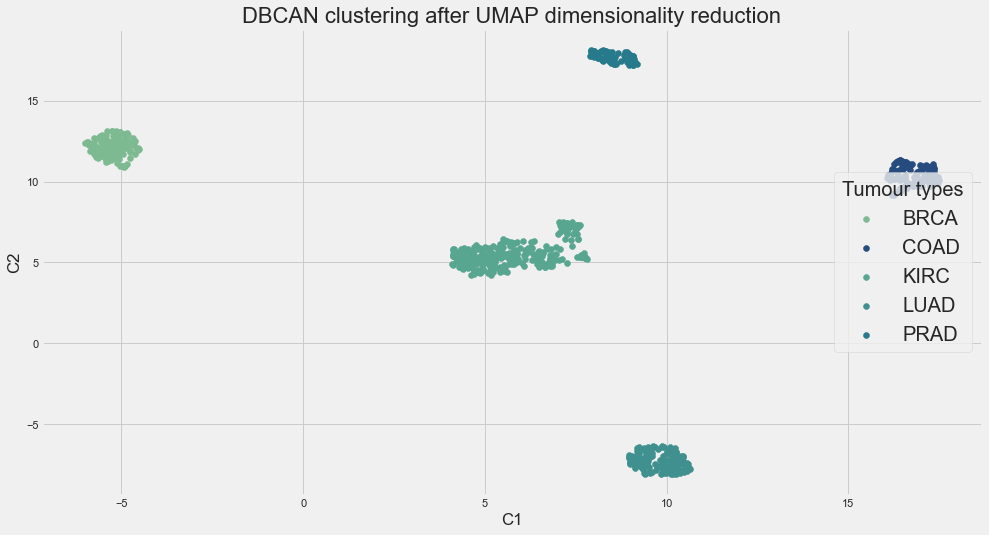

In [50]:
#Getting unique labels
 
u_labels = np.unique(Y_pred)
fig, ax = plt.subplots()
#plotting the results:
color=["#7dba91","#254b7f",'#58a590','#3f908e','#277a8b','#1c6388']
for i,w in enumerate(u_labels):
    plt.scatter(X2_processed[Y_pred == w , 0] , X2_processed[Y_pred == w , 1] , label = w,color=color[i])
plt.legend()
plt.rcParams["figure.figsize"] = (20,15)
ax.legend(fontsize=20, title='Tumour types',title_fontsize=20,loc=5,labels=['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'])
plt.title('DBCAN clustering after UMAP dimensionality reduction',fontsize=22)
plt.xlabel('C1')

plt.ylabel('C2')
plt.show()

In [51]:
Y_pred=KMeans(
                init="k-means++",
                  n_init=50,
                  max_iter=500,
                 random_state=999,
                 n_clusters=5
              ).fit(X2_processed)
print(silhouette_score(X2_processed, Y_pred.labels_))
print(adjusted_rand_score(Y2['Class'], Y_pred.labels_))

0.9022232
0.9962578040012737


In [52]:
df = pd.DataFrame()
df['Cluster'] = Y_pred.labels_
df['Binary Cluster 0'] = df['Cluster'].map({0:1, 1:0, 2:0, 3:0, 4:0})
df['Binary Cluster 1'] = df['Cluster'].map({0:0, 1:1, 2:0, 3:0, 4:0})
df['Binary Cluster 2'] = df['Cluster'].map({0:0, 1:0, 2:1, 3:0, 4:0})
df['Binary Cluster 3'] = df['Cluster'].map({0:0, 1:0, 2:0, 3:1, 4:0})
df['Binary Cluster 4'] = df['Cluster'].map({0:0, 1:0, 2:0, 3:0, 4:1})



In [53]:
df.iloc[:,1]

0      1
1      0
2      1
3      1
4      0
      ..
796    0
797    0
798    0
799    1
800    1
Name: Binary Cluster 0, Length: 801, dtype: int64

In [54]:
def generate_feature_importance(df):
    clf = RandomForestClassifier(random_state=999)
    data = []
    for i in range(1,6):
        
        clf.fit(X2, df.iloc[:,i].values)
        sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1]
        most_important_features = np.take_along_axis(np.array(X2.iloc[:, :].columns.tolist()), sorted_feature_weight_idxes, axis=0)
        most_important_weights = np.take_along_axis(np.array(clf.feature_importances_), sorted_feature_weight_idxes, axis=0)
        data.append(list(zip(most_important_features, most_important_weights))[0:20])
    return data

def generate_arrays(data):
    data_X = []
    data_Y = []
    for i,cluster in enumerate(data):
        for w,feature in enumerate(cluster):
            data_X.append(feature[1])
            data_Y.append(feature[0])
    return data_X,data_Y

def importance_plot2(b_feat, score,data):   
    plt.figure(figsize=(25,20))
    count = 0
    for i in range(1,6):
        
        plt.subplot(3, 3, i)
        plt.barh(b_feat[0+count*20:20*(count+1)], score[0+count*20:20*(count+1)], align='center',  color="#254b7f")
        plt.title('Importance of gene expression for ' +data[i-1]+' tumor')
        plt.xlabel("Importance (Mean Decrease In Impurity)")
        plt.ylabel("Features Ordered In Importance")
        count+=1
    
    plt.show()
            


In [55]:
data = generate_feature_importance(df)


KeyboardInterrupt: 

In [ ]:
data_X,data_Y=generate_arrays(data)

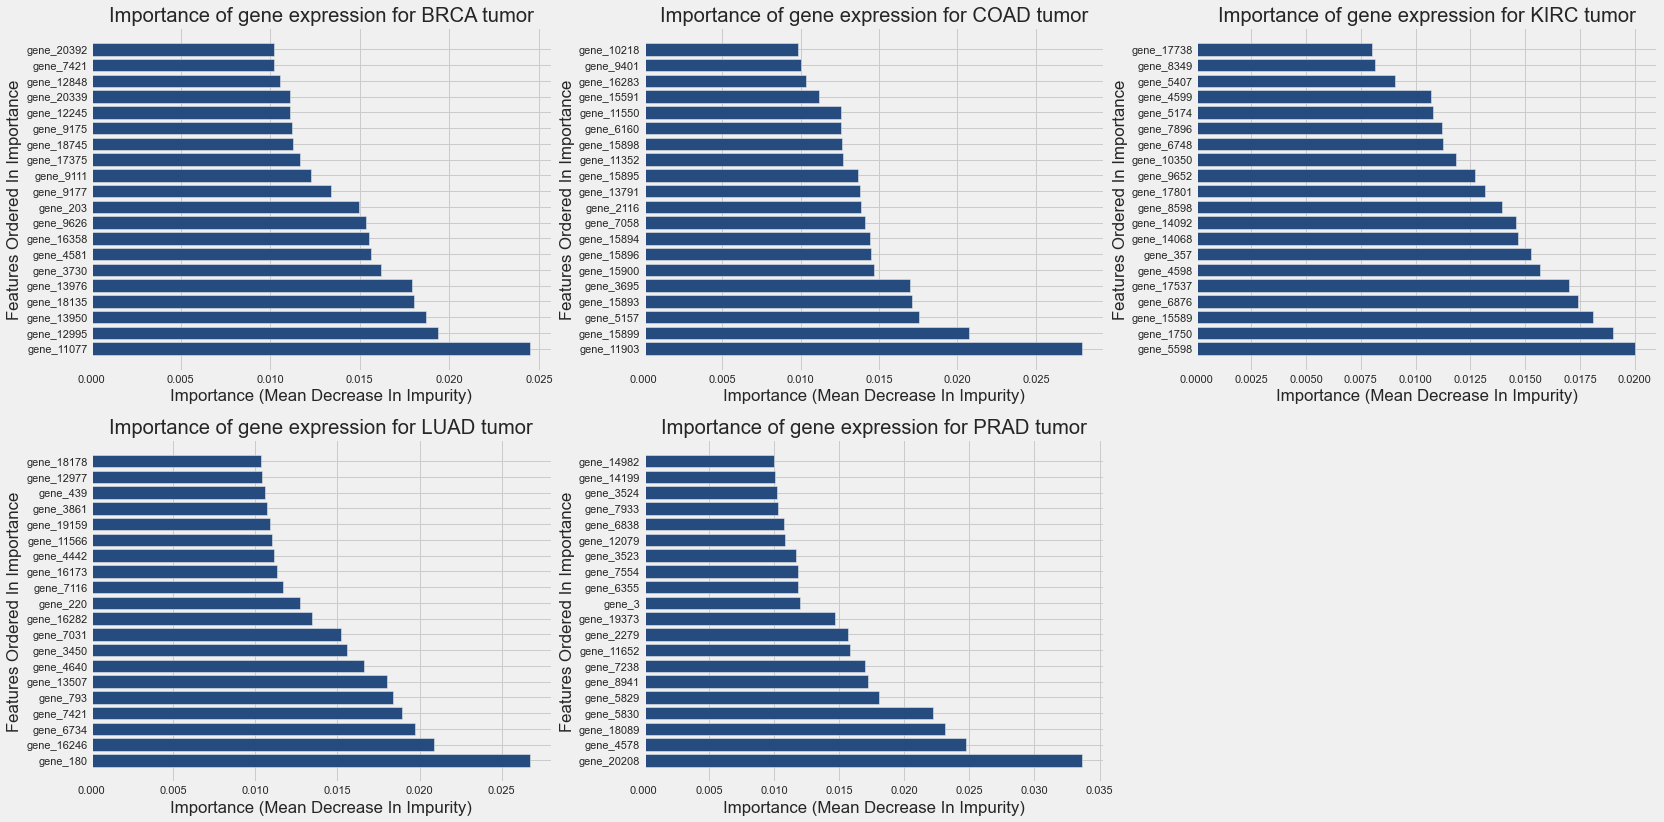

In [ ]:
tumors = ['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD']
importance_plot2(data_Y, data_X,tumors)